# Embed complaints and then use embeddings to predict positive or negative

In [143]:
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gradio as gr
import json


In [144]:
# get the API key from the json file
with open('openai_key.json') as f:
    data = json.load(f)
    api_key = data['OPENAI_API_KEY']
    openai.api_key = api_key

In [145]:
# load the complaints from csv format into a dataframe
complaints = pd.read_csv('banking_service_varied_comments.csv')
# loop over complaints and get the embeddings
embeddings = []
for complaint in complaints['Complaint']:
    model="text-embedding-ada-002"
    vec = openai.Embedding.create(input = [complaint], model=model)['data'][0]['embedding']
    embeddings.append(vec)
# add the embeddings to the dataframe
complaints['embeddings'] = embeddings
complaints.head()
# save the dataframe to csv for later use
complaints.to_csv('comments_Embed.csv')


In [178]:
# Read complaints in and map the categories to numbers in Area
complaints = pd.read_csv('comments_Embed.csv')
categories = complaints['Category'].unique()    # unique categories
category_map = {}
for i in range(len(categories)):   # map the catagories to numbers
    category_map[categories[i]] = i
# add the category numbers to the dataframe
complaints['Area'] = complaints['Category'].map(category_map)
complaints[:10]

,Unnamed: 0,Category,Score,Complaint,embeddings,Area
0,0,Online and Mobile Banking,-1,"The mobile app crashes frequently, making it u...","[-0.023478509858250618, -0.003465280868113041,...",0
1,1,Credit Cards,1,The low interest rates are a big plus for me.,"[-0.033650778234004974, -0.0003719516389537602...",1
2,2,Online and Mobile Banking,-1,The online banking system experiences frequent...,"[-0.03475111350417137, -0.025881528854370117, ...",0
3,3,Loans and Mortgages,-1,I was surprised by the hidden fees that were n...,"[0.011091673746705055, -0.005718418397009373, ...",2
4,4,Investment Services,1,The low management fees make it an attractive ...,"[-0.006059455219656229, -0.0028847488574683666...",3
5,5,Online and Mobile Banking,-1,"The mobile app crashes frequently, making it u...","[-0.023460088297724724, -0.0034612168092280626...",0
6,6,Investment Services,-1,The portfolio options are limited and not suit...,"[-0.02556699328124523, -0.04389537125825882, 0...",3
7,7,Credit Cards,1,Customer service was very helpful in resolving...,"[-0.003974739462137222, 0.006052590906620026, ...",1
8,8,Credit Cards,-1,The interest rates are much higher compared to...,"[-0.021048400551080704, -1.5677176634198986e-0...",1
9,9,Credit Cards,1,I appreciate the absence of annual fees on thi...,"[-0.024668579921126366, 0.013879268430173397, ...",1


### Dataframe of embeddings causes problems. We need to be careful because "complaints.embeddings" is a Pandas Series and we need a Numpy matrix ie array of arrays. 

(100, 2)
[0 1 0 2 3 0 3 1 1 1 0 2 2 1 0 2 3 1 0 3 2 3 3 2 2 0 3 3 0 0 0 1 2 2 1 0 1
 0 0 2 3 0 2 0 3 3 1 3 2 0 1 1 3 3 2 2 3 0 3 1 3 3 1 2 2 3 2 2 2 3 2 2 1 2
 0 2 3 1 2 0 0 1 1 1 2 1 0 0 2 3 0 2 0 3 1 1 0 2 2 1]


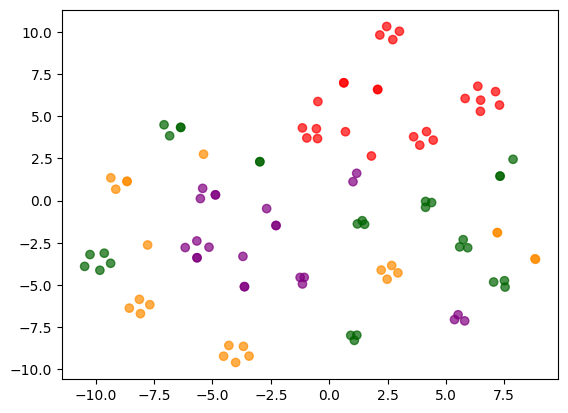

In [154]:
# plot the embeddings clusters using TSNE - remember complaints is a dataframe
from sklearn.manifold import TSNE
import matplotlib
from ast import literal_eval
tsne = TSNE(n_components=2, random_state=3)
# convert Pandas embedding array to a numpy array of arrays
# The matrix is calculated from the ebmeddings 
matrix = np.array(complaints.embeddings.apply(literal_eval).to_list())  # this is the line that takes a while

X_2d = tsne.fit_transform(matrix)
print(X_2d.shape)
colors = ["red", "darkorange",  "blue", "darkgreen","purple"]
x = [x for x,y in X_2d]
y = [y for x,y in X_2d]
color_indices = complaints.Area.values 
print(color_indices)
colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.7)
plt.show()

In [179]:
# split the data into training and test sets for classification of Score from the embeddings
# Score = sentiment,  Area = product category
from sklearn.model_selection import train_test_split

matrix = np.array(complaints.embeddings.apply(literal_eval).to_list())
X_train, X_test, y_train, y_test = train_test_split(
    complaints.embeddings.apply(literal_eval).to_list(),
    complaints.Score.values,  # Score = +1 or -1 AND Area = 0,1,2,3 
    test_size = 0.2,
    random_state=42
)
# print lenght of training set
print(len(X_train))

80


In [180]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=10) # n_estimators is the number of trees
rfr.fit(X_train, y_train)
preds = rfr.predict(X_test)
print(preds)
# these should be +1 or -1 for the sentiment and Areas 0,1,2,3 for the product categories

[ 0.8 -0.8  1.   1.  -0.8  1.  -0.8 -1.   1.  -1.   0.   0.6 -1.  -1.
  0.4  1.   1.  -1.   1.   1. ]


In [181]:
# compare the predictions to the actual scores
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, preds))
print(rmse)

0.28982753492378877
